### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test/2))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = np.random.uniform(0, 1, int(n_test/2))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = np.random.uniform(0, 1, int(n_samples/2))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = np.random.uniform(0, 1, int(n_samples/2))
for b in b_values:
    rho, label = ρ2(b)  # rho es matriz 4x4, label = 2
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 30  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 1000
batch_size = int(len(data_train)*0.2)
val_batch_size=int(0.2*batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float('inf')
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):
    
    # Seleccionar un batch aleatorio de data_train
    batch = random.sample(data_train, batch_size)
    
    # Paso de entrenamiento con el batch
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)
    
    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)




    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        break

    # Evaluación en train y test
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_test, err_test, inc_test = evaluate_model(params, data_test)

    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")




Entrenando:   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/1000 [06:58<116:15:45, 418.96s/it]

Entrenando:   0%|          | 2/1000 [13:55<115:47:02, 417.66s/it]

Entrenando:   0%|          | 3/1000 [20:53<115:38:33, 417.57s/it]

Entrenando:   0%|          | 4/1000 [27:50<115:28:44, 417.39s/it]

Entrenando:   0%|          | 5/1000 [35:13<117:58:38, 426.85s/it]

Entrenando:   1%|          | 6/1000 [42:49<120:30:55, 436.47s/it]

Entrenando:   1%|          | 7/1000 [50:24<122:07:12, 442.73s/it]

Entrenando:   1%|          | 8/1000 [57:59<123:05:26, 446.70s/it]

Entrenando:   1%|          | 9/1000 [1:05:34<123:40:51, 449.30s/it]

Entrenando:   1%|          | 10/1000 [1:13:10<124:05:22, 451.23s/it]

Entrenando:   1%|          | 11/1000 [1:20:46<124:21:33, 452.67s/it]

Entrenando:   1%|          | 12/1000 [1:28:21<124:28:30, 453.55s/it]

Entrenando:   1%|▏         | 13/1000 [1:35:59<124:38:35, 454.63s/it]

Entrenando:   1%|▏         | 14/1000 [1:42:56<121:28:35, 443.52s/it]

Entrenando:   2%|▏         | 15/1000 [1:49:56<119:23:31, 436.36s/it]

Entrenando:   2%|▏         | 16/1000 [1:56:54<117:47:14, 430.93s/it]

Entrenando:   2%|▏         | 17/1000 [2:03:52<116:33:07, 426.84s/it]

Entrenando:   2%|▏         | 18/1000 [2:10:51<115:46:29, 424.43s/it]

Entrenando:   2%|▏         | 19/1000 [2:17:50<115:15:01, 422.94s/it]

Entrenando:   2%|▏         | 20/1000 [2:24:50<114:54:29, 422.11s/it]

Entrenando:   2%|▏         | 21/1000 [2:31:46<114:16:32, 420.22s/it]

Entrenando:   2%|▏         | 22/1000 [2:38:45<114:04:40, 419.92s/it]

Entrenando:   2%|▏         | 23/1000 [2:45:43<113:45:54, 419.20s/it]

Entrenando:   2%|▏         | 24/1000 [2:52:41<113:32:12, 418.78s/it]

Entrenando:   2%|▎         | 25/1000 [2:59:38<113:18:41, 418.38s/it]

Entrenando:   3%|▎         | 26/1000 [3:06:37<113:14:31, 418.55s/it]

Entrenando:   3%|▎         | 27/1000 [3:13:35<113:06:18, 418.48s/it]

Entrenando:   3%|▎         | 28/1000 [3:20:33<112:55:47, 418.26s/it]

Entrenando:   3%|▎         | 29/1000 [3:27:29<112:36:24, 417.49s/it]

Entrenando:   3%|▎         | 30/1000 [3:34:28<112:38:52, 418.07s/it]

Entrenando:   3%|▎         | 31/1000 [3:41:26<112:31:33, 418.05s/it]

Entrenando:   3%|▎         | 32/1000 [3:48:24<112:21:25, 417.86s/it]

Entrenando:   3%|▎         | 33/1000 [3:55:22<112:15:26, 417.92s/it]

Entrenando:   3%|▎         | 34/1000 [4:02:19<112:03:21, 417.60s/it]

Entrenando:   4%|▎         | 35/1000 [4:09:19<112:08:04, 418.33s/it]

Entrenando:   4%|▎         | 36/1000 [4:16:17<112:01:06, 418.33s/it]

Entrenando:   4%|▎         | 37/1000 [4:23:16<111:59:30, 418.66s/it]

Entrenando:   4%|▍         | 38/1000 [4:30:14<111:48:45, 418.43s/it]

Entrenando:   4%|▍         | 39/1000 [4:37:12<111:37:40, 418.17s/it]

Entrenando:   4%|▍         | 40/1000 [4:44:08<111:19:27, 417.47s/it]

Entrenando:   4%|▍         | 41/1000 [4:51:06<111:17:17, 417.77s/it]

Entrenando:   4%|▍         | 42/1000 [4:58:05<111:14:11, 418.01s/it]

Entrenando:   4%|▍         | 43/1000 [5:05:02<111:05:54, 417.92s/it]

Entrenando:   4%|▍         | 44/1000 [5:12:01<111:01:38, 418.10s/it]

Entrenando:   4%|▍         | 45/1000 [5:18:58<110:51:25, 417.89s/it]

Entrenando:   5%|▍         | 46/1000 [5:25:57<110:47:46, 418.10s/it]

Entrenando:   5%|▍         | 47/1000 [5:32:55<110:40:50, 418.10s/it]

Entrenando:   5%|▍         | 48/1000 [5:39:53<110:32:58, 418.04s/it]

Entrenando:   5%|▍         | 49/1000 [5:46:50<110:19:12, 417.62s/it]

Entrenando:   5%|▌         | 50/1000 [5:53:48<110:15:20, 417.81s/it]

Iter  50: train_loss=7.5046, val_loss=11.6672, train_suc=0.446, train_err=0.265, train_inc=0.289 | test_suc=0.408, test_err=0.279, test_inc=0.314


Entrenando:   5%|▌         | 51/1000 [6:00:47<110:13:40, 418.15s/it]

Entrenando:   5%|▌         | 52/1000 [6:07:47<110:17:00, 418.80s/it]

Entrenando:   5%|▌         | 53/1000 [6:14:46<110:08:35, 418.71s/it]

Entrenando:   5%|▌         | 54/1000 [6:21:45<110:05:54, 418.98s/it]

Entrenando:   6%|▌         | 55/1000 [6:28:43<109:51:42, 418.52s/it]

Entrenando:   6%|▌         | 56/1000 [6:35:42<109:47:57, 418.73s/it]

Entrenando:   6%|▌         | 57/1000 [6:42:40<109:36:58, 418.47s/it]

Entrenando:   6%|▌         | 58/1000 [6:49:40<109:36:37, 418.89s/it]

Entrenando:   6%|▌         | 59/1000 [6:56:35<109:15:38, 418.00s/it]

Entrenando:   6%|▌         | 60/1000 [7:03:35<109:14:27, 418.37s/it]

Entrenando:   6%|▌         | 61/1000 [7:10:34<109:11:08, 418.60s/it]

Entrenando:   6%|▌         | 62/1000 [7:17:34<109:13:33, 419.20s/it]

Entrenando:   6%|▋         | 63/1000 [7:24:32<109:00:28, 418.81s/it]

Entrenando:   6%|▋         | 64/1000 [7:31:31<108:53:21, 418.81s/it]

Entrenando:   6%|▋         | 65/1000 [7:38:51<110:23:06, 425.01s/it]

Entrenando:   7%|▋         | 66/1000 [7:46:18<112:02:16, 431.84s/it]

Entrenando:   7%|▋         | 67/1000 [7:53:15<110:41:43, 427.12s/it]

Entrenando:   7%|▋         | 68/1000 [8:00:14<109:57:36, 424.74s/it]

Entrenando:   7%|▋         | 69/1000 [8:07:13<109:23:00, 422.97s/it]

Entrenando:   7%|▋         | 70/1000 [8:14:10<108:50:39, 421.33s/it]

Entrenando:   7%|▋         | 71/1000 [8:21:08<108:26:32, 420.23s/it]

Entrenando:   7%|▋         | 72/1000 [8:28:07<108:13:46, 419.86s/it]

Entrenando:   7%|▋         | 73/1000 [8:35:05<107:58:05, 419.29s/it]

Entrenando:   7%|▋         | 74/1000 [8:42:02<107:42:32, 418.74s/it]

Entrenando:   8%|▊         | 75/1000 [8:48:59<107:28:39, 418.29s/it]

Entrenando:   8%|▊         | 76/1000 [8:55:58<107:21:51, 418.30s/it]

Entrenando:   8%|▊         | 77/1000 [9:02:55<107:10:48, 418.04s/it]

Entrenando:   8%|▊         | 78/1000 [9:09:51<106:53:01, 417.33s/it]

Entrenando:   8%|▊         | 79/1000 [9:16:48<106:43:49, 417.19s/it]

Entrenando:   8%|▊         | 80/1000 [9:23:46<106:43:36, 417.63s/it]

Entrenando:   8%|▊         | 81/1000 [9:30:43<106:32:47, 417.37s/it]

Entrenando:   8%|▊         | 82/1000 [9:37:41<106:26:32, 417.42s/it]

Entrenando:   8%|▊         | 83/1000 [9:44:37<106:16:03, 417.19s/it]

Entrenando:   8%|▊         | 84/1000 [9:51:36<106:15:05, 417.58s/it]

Entrenando:   8%|▊         | 85/1000 [9:58:32<106:04:04, 417.32s/it]

Entrenando:   9%|▊         | 86/1000 [10:05:32<106:05:18, 417.85s/it]

Entrenando:   9%|▊         | 87/1000 [10:12:30<106:02:43, 418.14s/it]

Entrenando:   9%|▉         | 88/1000 [10:19:27<105:49:36, 417.74s/it]

Entrenando:   9%|▉         | 89/1000 [10:26:25<105:41:13, 417.64s/it]

Entrenando:   9%|▉         | 90/1000 [10:33:23<105:39:48, 418.01s/it]

Entrenando:   9%|▉         | 91/1000 [10:40:21<105:31:39, 417.93s/it]

Entrenando:   9%|▉         | 92/1000 [10:47:19<105:25:16, 417.97s/it]

Entrenando:   9%|▉         | 93/1000 [10:54:17<105:16:06, 417.82s/it]

Entrenando:   9%|▉         | 94/1000 [11:01:15<105:10:20, 417.90s/it]

Entrenando:  10%|▉         | 95/1000 [11:08:15<105:12:49, 418.53s/it]

Entrenando:  10%|▉         | 96/1000 [11:15:13<105:02:03, 418.28s/it]

Entrenando:  10%|▉         | 97/1000 [11:22:11<104:55:34, 418.31s/it]

Entrenando:  10%|▉         | 98/1000 [11:29:09<104:48:46, 418.32s/it]

Entrenando:  10%|▉         | 99/1000 [11:36:09<104:50:07, 418.88s/it]

Entrenando:  10%|█         | 100/1000 [11:43:08<104:40:32, 418.70s/it]

Iter 100: train_loss=6.8785, val_loss=8.9952, train_suc=0.464, train_err=0.214, train_inc=0.322 | test_suc=0.422, test_err=0.218, test_inc=0.360


Entrenando:  10%|█         | 101/1000 [11:50:43<107:17:33, 429.65s/it]

Entrenando:  10%|█         | 102/1000 [11:58:18<109:04:48, 437.29s/it]

Entrenando:  10%|█         | 103/1000 [12:05:55<110:24:26, 443.11s/it]

Entrenando:  10%|█         | 104/1000 [12:13:30<111:12:41, 446.83s/it]

Entrenando:  10%|█         | 105/1000 [12:21:05<111:40:37, 449.20s/it]

Entrenando:  11%|█         | 106/1000 [12:28:40<111:58:29, 450.91s/it]

Entrenando:  11%|█         | 107/1000 [12:35:41<109:36:31, 441.87s/it]

Entrenando:  11%|█         | 108/1000 [12:43:10<110:00:40, 443.99s/it]

Entrenando:  11%|█         | 109/1000 [12:50:46<110:46:25, 447.57s/it]

Entrenando:  11%|█         | 110/1000 [12:57:54<109:15:15, 441.93s/it]

Entrenando:  11%|█         | 111/1000 [13:04:52<107:21:59, 434.78s/it]

Entrenando:  11%|█         | 112/1000 [13:11:49<105:54:11, 429.34s/it]

Entrenando:  11%|█▏        | 113/1000 [13:18:47<104:56:15, 425.90s/it]

Entrenando:  11%|█▏        | 114/1000 [13:25:44<104:11:34, 423.36s/it]

Entrenando:  12%|█▏        | 115/1000 [13:32:42<103:37:18, 421.51s/it]

Entrenando:  12%|█▏        | 116/1000 [13:39:41<103:21:21, 420.91s/it]

Entrenando:  12%|█▏        | 117/1000 [13:46:40<103:04:18, 420.22s/it]

Entrenando:  12%|█▏        | 118/1000 [13:53:38<102:49:13, 419.67s/it]

Entrenando:  12%|█▏        | 119/1000 [14:00:36<102:34:09, 419.13s/it]

Entrenando:  12%|█▏        | 120/1000 [14:07:35<102:25:57, 419.04s/it]

Entrenando:  12%|█▏        | 121/1000 [14:14:30<102:03:47, 418.01s/it]

Entrenando:  12%|█▏        | 122/1000 [14:21:28<101:55:25, 417.91s/it]

Entrenando:  12%|█▏        | 123/1000 [14:28:25<101:44:32, 417.64s/it]

Entrenando:  12%|█▏        | 124/1000 [14:35:22<101:36:16, 417.55s/it]

Entrenando:  12%|█▎        | 125/1000 [14:42:20<101:30:06, 417.61s/it]

Entrenando:  13%|█▎        | 126/1000 [14:49:19<101:29:16, 418.03s/it]

Entrenando:  13%|█▎        | 127/1000 [14:56:16<101:17:02, 417.67s/it]

Entrenando:  13%|█▎        | 128/1000 [15:03:14<101:12:44, 417.85s/it]

Entrenando:  13%|█▎        | 129/1000 [15:10:12<101:06:17, 417.88s/it]

Entrenando:  13%|█▎        | 130/1000 [15:17:08<100:50:04, 417.25s/it]

Entrenando:  13%|█▎        | 131/1000 [15:24:06<100:45:05, 417.38s/it]

Entrenando:  13%|█▎        | 132/1000 [15:31:04<100:43:15, 417.74s/it]

Entrenando:  13%|█▎        | 133/1000 [15:38:03<100:41:22, 418.09s/it]

Entrenando:  13%|█▎        | 134/1000 [15:45:00<100:27:24, 417.60s/it]

Entrenando:  14%|█▎        | 135/1000 [15:51:56<100:15:48, 417.28s/it]

Entrenando:  14%|█▎        | 136/1000 [15:58:54<100:11:59, 417.50s/it]

Entrenando:  14%|█▎        | 137/1000 [16:05:52<100:08:20, 417.73s/it]

Entrenando:  14%|█▍        | 138/1000 [16:12:50<100:00:05, 417.64s/it]

Entrenando:  14%|█▍        | 139/1000 [16:19:49<99:59:09, 418.06s/it] 

Entrenando:  14%|█▍        | 140/1000 [16:26:49<100:01:14, 418.69s/it]

Entrenando:  14%|█▍        | 141/1000 [16:33:47<99:52:42, 418.58s/it] 

Entrenando:  14%|█▍        | 142/1000 [16:40:45<99:40:49, 418.24s/it]

Entrenando:  14%|█▍        | 143/1000 [16:47:42<99:29:42, 417.95s/it]

Entrenando:  14%|█▍        | 144/1000 [16:54:41<99:25:42, 418.16s/it]

Entrenando:  14%|█▍        | 145/1000 [17:01:37<99:09:47, 417.53s/it]

Entrenando:  15%|█▍        | 146/1000 [17:08:33<98:58:25, 417.22s/it]

Entrenando:  15%|█▍        | 147/1000 [17:15:31<98:55:29, 417.50s/it]

Entrenando:  15%|█▍        | 148/1000 [17:23:04<101:18:56, 428.09s/it]

Entrenando:  15%|█▍        | 149/1000 [17:30:40<103:08:23, 436.31s/it]

Entrenando:  15%|█▌        | 150/1000 [17:38:16<104:27:03, 442.38s/it]

Iter 150: train_loss=4.7353, val_loss=6.8117, train_suc=0.526, train_err=0.185, train_inc=0.289 | test_suc=0.478, test_err=0.177, test_inc=0.344


Entrenando:  15%|█▌        | 151/1000 [17:45:52<105:14:49, 446.28s/it]

Entrenando:  15%|█▌        | 152/1000 [17:53:27<105:47:05, 449.09s/it]

Entrenando:  15%|█▌        | 153/1000 [18:01:03<106:06:14, 450.97s/it]

Entrenando:  15%|█▌        | 154/1000 [18:08:39<106:22:32, 452.66s/it]

Entrenando:  16%|█▌        | 155/1000 [18:16:15<106:27:03, 453.52s/it]

Entrenando:  16%|█▌        | 156/1000 [18:23:50<106:27:26, 454.08s/it]

Entrenando:  16%|█▌        | 157/1000 [18:31:26<106:28:05, 454.67s/it]

Entrenando:  16%|█▌        | 158/1000 [18:39:02<106:23:43, 454.90s/it]

Entrenando:  16%|█▌        | 159/1000 [18:46:38<106:20:57, 455.24s/it]

Entrenando:  16%|█▌        | 160/1000 [18:54:12<106:11:07, 455.08s/it]

Entrenando:  16%|█▌        | 161/1000 [19:01:48<106:04:31, 455.15s/it]

Entrenando:  16%|█▌        | 162/1000 [19:09:24<106:00:18, 455.39s/it]

Entrenando:  16%|█▋        | 163/1000 [19:16:58<105:47:39, 455.03s/it]

Entrenando:  16%|█▋        | 164/1000 [19:24:34<105:43:34, 455.28s/it]

Entrenando:  16%|█▋        | 165/1000 [19:32:07<105:27:00, 454.64s/it]

Entrenando:  17%|█▋        | 166/1000 [19:39:43<105:24:46, 455.02s/it]

Entrenando:  17%|█▋        | 167/1000 [19:47:19<105:21:48, 455.35s/it]

Entrenando:  17%|█▋        | 168/1000 [19:54:48<104:47:34, 453.43s/it]

Entrenando:  17%|█▋        | 169/1000 [20:01:45<102:11:04, 442.68s/it]

Entrenando:  17%|█▋        | 170/1000 [20:09:11<102:17:47, 443.70s/it]

Entrenando:  17%|█▋        | 171/1000 [20:16:47<103:00:49, 447.35s/it]

Entrenando:  17%|█▋        | 172/1000 [20:24:23<103:26:18, 449.73s/it]

Entrenando:  17%|█▋        | 173/1000 [20:31:33<101:56:42, 443.78s/it]

Entrenando:  17%|█▋        | 174/1000 [20:38:31<100:03:03, 436.06s/it]

Entrenando:  18%|█▊        | 175/1000 [20:45:29<98:42:27, 430.72s/it] 

Entrenando:  18%|█▊        | 176/1000 [20:52:27<97:41:40, 426.82s/it]

Entrenando:  18%|█▊        | 177/1000 [20:59:25<96:58:37, 424.20s/it]

Entrenando:  18%|█▊        | 178/1000 [21:06:22<96:24:32, 422.23s/it]

Entrenando:  18%|█▊        | 179/1000 [21:13:20<96:00:41, 421.00s/it]

Entrenando:  18%|█▊        | 180/1000 [21:20:19<95:43:13, 420.24s/it]

Entrenando:  18%|█▊        | 181/1000 [21:27:18<95:33:26, 420.03s/it]

Entrenando:  18%|█▊        | 182/1000 [21:34:17<95:18:36, 419.46s/it]

Entrenando:  18%|█▊        | 183/1000 [21:41:14<95:04:45, 418.95s/it]

Entrenando:  18%|█▊        | 184/1000 [21:48:13<94:57:25, 418.93s/it]

Entrenando:  18%|█▊        | 185/1000 [21:55:13<94:54:31, 419.23s/it]

Entrenando:  19%|█▊        | 186/1000 [22:02:12<94:44:06, 418.98s/it]

Entrenando:  19%|█▊        | 187/1000 [22:09:12<94:43:08, 419.42s/it]

Entrenando:  19%|█▉        | 188/1000 [22:16:10<94:29:32, 418.93s/it]

Entrenando:  19%|█▉        | 189/1000 [22:23:09<94:21:56, 418.89s/it]

Entrenando:  19%|█▉        | 190/1000 [22:30:06<94:10:04, 418.52s/it]

Entrenando:  19%|█▉        | 191/1000 [22:37:04<94:00:12, 418.31s/it]

Entrenando:  19%|█▉        | 192/1000 [22:44:01<93:49:38, 418.04s/it]

Entrenando:  19%|█▉        | 193/1000 [22:51:01<93:46:54, 418.36s/it]

Entrenando:  19%|█▉        | 194/1000 [22:57:58<93:37:30, 418.18s/it]

Entrenando:  20%|█▉        | 195/1000 [23:04:58<93:34:50, 418.50s/it]

Entrenando:  20%|█▉        | 196/1000 [23:11:57<93:31:06, 418.74s/it]

Entrenando:  20%|█▉        | 197/1000 [23:18:55<93:23:17, 418.68s/it]

Entrenando:  20%|█▉        | 198/1000 [23:25:52<93:10:04, 418.21s/it]

Entrenando:  20%|█▉        | 199/1000 [23:32:52<93:09:11, 418.67s/it]

Entrenando:  20%|██        | 200/1000 [23:39:50<92:58:52, 418.42s/it]

Iter 200: train_loss=12.7759, val_loss=5.9167, train_suc=0.561, train_err=0.173, train_inc=0.266 | test_suc=0.511, test_err=0.162, test_inc=0.328


Entrenando:  20%|██        | 201/1000 [23:46:48<92:48:36, 418.17s/it]

Entrenando:  20%|██        | 202/1000 [23:53:45<92:36:36, 417.79s/it]

Entrenando:  20%|██        | 203/1000 [24:00:41<92:25:43, 417.50s/it]

Entrenando:  20%|██        | 204/1000 [24:07:39<92:20:02, 417.59s/it]

Entrenando:  20%|██        | 205/1000 [24:14:38<92:17:18, 417.91s/it]

Entrenando:  21%|██        | 206/1000 [24:21:35<92:08:26, 417.77s/it]

Entrenando:  21%|██        | 207/1000 [24:28:34<92:05:52, 418.10s/it]

Entrenando:  21%|██        | 208/1000 [24:35:33<92:00:16, 418.20s/it]

Entrenando:  21%|██        | 209/1000 [24:42:30<91:51:11, 418.04s/it]

Entrenando:  21%|██        | 210/1000 [24:49:28<91:42:36, 417.92s/it]

Entrenando:  21%|██        | 211/1000 [24:56:26<91:35:31, 417.91s/it]

Entrenando:  21%|██        | 212/1000 [25:03:25<91:34:40, 418.38s/it]

Entrenando:  21%|██▏       | 213/1000 [25:10:22<91:22:56, 418.01s/it]

Entrenando:  21%|██▏       | 214/1000 [25:17:21<91:17:16, 418.11s/it]

Entrenando:  22%|██▏       | 215/1000 [25:24:20<91:13:29, 418.36s/it]

Entrenando:  22%|██▏       | 216/1000 [25:31:17<91:03:14, 418.10s/it]

Entrenando:  22%|██▏       | 217/1000 [25:38:13<90:47:13, 417.41s/it]

Entrenando:  22%|██▏       | 218/1000 [25:45:09<90:36:06, 417.09s/it]

Entrenando:  22%|██▏       | 219/1000 [25:52:08<90:36:20, 417.65s/it]

Entrenando:  22%|██▏       | 220/1000 [25:59:06<90:30:02, 417.70s/it]

Entrenando:  22%|██▏       | 221/1000 [26:06:04<90:22:43, 417.67s/it]

Entrenando:  22%|██▏       | 222/1000 [26:13:02<90:19:18, 417.94s/it]

Entrenando:  22%|██▏       | 223/1000 [26:20:02<90:17:34, 418.35s/it]

Entrenando:  22%|██▏       | 224/1000 [26:26:59<90:06:09, 418.00s/it]

Entrenando:  22%|██▎       | 225/1000 [26:33:58<90:04:33, 418.42s/it]

Entrenando:  23%|██▎       | 226/1000 [26:40:56<89:55:04, 418.22s/it]

Entrenando:  23%|██▎       | 227/1000 [26:47:54<89:48:21, 418.24s/it]

Entrenando:  23%|██▎       | 228/1000 [26:54:51<89:35:18, 417.77s/it]

Entrenando:  23%|██▎       | 229/1000 [27:01:48<89:26:58, 417.66s/it]

Entrenando:  23%|██▎       | 230/1000 [27:08:44<89:13:49, 417.18s/it]

Entrenando:  23%|██▎       | 231/1000 [27:15:42<89:09:09, 417.36s/it]

Entrenando:  23%|██▎       | 232/1000 [27:23:19<91:32:20, 429.09s/it]

Entrenando:  23%|██▎       | 233/1000 [27:30:55<93:08:14, 437.15s/it]

Entrenando:  23%|██▎       | 234/1000 [27:38:30<94:09:50, 442.55s/it]

Entrenando:  24%|██▎       | 235/1000 [27:46:05<94:49:38, 446.25s/it]

Entrenando:  24%|██▎       | 236/1000 [27:53:40<95:18:52, 449.13s/it]

Entrenando:  24%|██▎       | 237/1000 [28:01:16<95:35:50, 451.05s/it]

Entrenando:  24%|██▍       | 238/1000 [28:08:52<95:46:15, 452.46s/it]

Entrenando:  24%|██▍       | 239/1000 [28:16:28<95:52:02, 453.51s/it]

Entrenando:  24%|██▍       | 240/1000 [28:24:03<95:52:15, 454.13s/it]

Entrenando:  24%|██▍       | 241/1000 [28:31:39<95:51:55, 454.70s/it]

Entrenando:  24%|██▍       | 242/1000 [28:38:39<93:32:01, 444.22s/it]

Entrenando:  24%|██▍       | 243/1000 [28:45:36<91:42:34, 436.14s/it]

Entrenando:  24%|██▍       | 244/1000 [28:53:10<92:43:30, 441.55s/it]

Entrenando:  24%|██▍       | 245/1000 [29:00:11<91:15:26, 435.13s/it]

Entrenando:  25%|██▍       | 246/1000 [29:07:10<90:08:13, 430.36s/it]

Entrenando:  25%|██▍       | 247/1000 [29:14:06<89:08:16, 426.16s/it]

Entrenando:  25%|██▍       | 248/1000 [29:21:04<88:30:42, 423.73s/it]

Entrenando:  25%|██▍       | 249/1000 [29:28:02<88:02:33, 422.04s/it]

Entrenando:  25%|██▌       | 250/1000 [29:35:00<87:37:39, 420.61s/it]

Iter 250: train_loss=4.3991, val_loss=5.7098, train_suc=0.574, train_err=0.167, train_inc=0.259 | test_suc=0.522, test_err=0.157, test_inc=0.321


Entrenando:  25%|██▌       | 251/1000 [29:41:58<87:23:59, 420.08s/it]

Entrenando:  25%|██▌       | 252/1000 [29:48:58<87:16:42, 420.06s/it]

Entrenando:  25%|██▌       | 253/1000 [29:55:57<87:04:49, 419.67s/it]

Entrenando:  25%|██▌       | 254/1000 [30:02:56<86:52:58, 419.27s/it]

Entrenando:  26%|██▌       | 255/1000 [30:09:54<86:41:12, 418.89s/it]

Entrenando:  26%|██▌       | 256/1000 [30:16:53<86:34:29, 418.91s/it]

Entrenando:  26%|██▌       | 257/1000 [30:23:50<86:22:23, 418.50s/it]

Entrenando:  26%|██▌       | 258/1000 [30:30:47<86:08:33, 417.94s/it]

Entrenando:  26%|██▌       | 259/1000 [30:37:46<86:06:15, 418.32s/it]

Entrenando:  26%|██▌       | 260/1000 [30:44:45<86:00:56, 418.46s/it]

Entrenando:  26%|██▌       | 261/1000 [30:51:43<85:55:00, 418.54s/it]

Entrenando:  26%|██▌       | 262/1000 [30:58:41<85:44:53, 418.28s/it]

Entrenando:  26%|██▋       | 263/1000 [31:05:40<85:38:48, 418.36s/it]

Entrenando:  26%|██▋       | 264/1000 [31:12:37<85:28:59, 418.12s/it]

Entrenando:  26%|██▋       | 265/1000 [31:19:33<85:13:05, 417.40s/it]

Entrenando:  27%|██▋       | 266/1000 [31:26:32<85:13:10, 417.97s/it]

Entrenando:  27%|██▋       | 267/1000 [31:33:30<85:06:26, 417.99s/it]

Entrenando:  27%|██▋       | 268/1000 [31:40:30<85:04:18, 418.39s/it]

Entrenando:  27%|██▋       | 269/1000 [31:47:27<84:52:26, 417.98s/it]

Entrenando:  27%|██▋       | 270/1000 [31:54:24<84:44:04, 417.87s/it]

Entrenando:  27%|██▋       | 271/1000 [32:01:22<84:36:05, 417.78s/it]

Entrenando:  27%|██▋       | 272/1000 [32:08:19<84:26:12, 417.54s/it]

Entrenando:  27%|██▋       | 273/1000 [32:15:16<84:17:19, 417.39s/it]

Entrenando:  27%|██▋       | 274/1000 [32:22:14<84:12:39, 417.58s/it]

Entrenando:  28%|██▊       | 275/1000 [32:29:12<84:07:53, 417.76s/it]

Entrenando:  28%|██▊       | 276/1000 [32:36:09<83:58:51, 417.58s/it]

Entrenando:  28%|██▊       | 277/1000 [32:43:07<83:53:04, 417.68s/it]

Entrenando:  28%|██▊       | 278/1000 [32:50:05<83:47:44, 417.82s/it]

Entrenando:  28%|██▊       | 279/1000 [32:57:04<83:45:47, 418.24s/it]

Entrenando:  28%|██▊       | 280/1000 [33:04:02<83:36:54, 418.08s/it]

Entrenando:  28%|██▊       | 281/1000 [33:11:01<83:31:30, 418.21s/it]

Entrenando:  28%|██▊       | 282/1000 [33:17:59<83:23:38, 418.13s/it]

Entrenando:  28%|██▊       | 283/1000 [33:24:55<83:11:21, 417.69s/it]

Entrenando:  28%|██▊       | 284/1000 [33:31:53<83:04:43, 417.71s/it]

Entrenando:  28%|██▊       | 285/1000 [33:38:50<82:55:17, 417.51s/it]

Entrenando:  29%|██▊       | 286/1000 [33:45:49<82:52:00, 417.82s/it]

Entrenando:  29%|██▊       | 287/1000 [33:52:46<82:45:01, 417.81s/it]

Entrenando:  29%|██▉       | 288/1000 [33:59:44<82:37:10, 417.74s/it]

Entrenando:  29%|██▉       | 289/1000 [34:06:42<82:31:10, 417.82s/it]

Entrenando:  29%|██▉       | 290/1000 [34:13:41<82:27:28, 418.10s/it]

Entrenando:  29%|██▉       | 291/1000 [34:20:38<82:18:05, 417.89s/it]

Entrenando:  29%|██▉       | 292/1000 [34:27:35<82:08:36, 417.68s/it]

Entrenando:  29%|██▉       | 293/1000 [34:34:33<82:02:28, 417.75s/it]

Entrenando:  29%|██▉       | 294/1000 [34:41:33<82:02:10, 418.32s/it]

Entrenando:  30%|██▉       | 295/1000 [34:48:28<81:44:26, 417.40s/it]

Entrenando:  30%|██▉       | 296/1000 [34:55:27<81:42:20, 417.81s/it]

Entrenando:  30%|██▉       | 297/1000 [35:02:25<81:37:24, 417.99s/it]

Entrenando:  30%|██▉       | 298/1000 [35:09:23<81:29:14, 417.88s/it]

Entrenando:  30%|██▉       | 299/1000 [35:16:20<81:20:07, 417.70s/it]

Entrenando:  30%|███       | 300/1000 [35:23:17<81:10:28, 417.47s/it]

Iter 300: train_loss=6.7641, val_loss=5.1581, train_suc=0.582, train_err=0.158, train_inc=0.260 | test_suc=0.530, test_err=0.147, test_inc=0.323


Entrenando:  30%|███       | 301/1000 [35:30:15<81:06:30, 417.73s/it]

Entrenando:  30%|███       | 302/1000 [35:37:14<81:00:59, 417.85s/it]

Entrenando:  30%|███       | 303/1000 [35:44:12<80:54:12, 417.87s/it]

Entrenando:  30%|███       | 304/1000 [35:51:12<80:54:36, 418.50s/it]

Entrenando:  30%|███       | 305/1000 [35:58:09<80:44:11, 418.20s/it]

Entrenando:  31%|███       | 306/1000 [36:05:06<80:33:34, 417.89s/it]

Entrenando:  31%|███       | 307/1000 [36:12:03<80:23:18, 417.60s/it]

Entrenando:  31%|███       | 308/1000 [36:19:03<80:23:36, 418.23s/it]

Entrenando:  31%|███       | 309/1000 [36:26:00<80:11:41, 417.80s/it]

Entrenando:  31%|███       | 310/1000 [36:32:57<80:01:55, 417.56s/it]

Entrenando:  31%|███       | 311/1000 [36:39:53<79:50:04, 417.13s/it]

Entrenando:  31%|███       | 312/1000 [36:46:51<79:46:49, 417.46s/it]

Entrenando:  31%|███▏      | 313/1000 [36:53:51<79:48:46, 418.23s/it]

Entrenando:  31%|███▏      | 314/1000 [37:00:48<79:37:36, 417.87s/it]

Entrenando:  32%|███▏      | 315/1000 [37:07:46<79:29:28, 417.76s/it]

Entrenando:  32%|███▏      | 316/1000 [37:14:44<79:23:35, 417.86s/it]

Entrenando:  32%|███▏      | 317/1000 [37:21:41<79:14:45, 417.69s/it]

Entrenando:  32%|███▏      | 318/1000 [37:28:39<79:08:55, 417.79s/it]

Entrenando:  32%|███▏      | 319/1000 [37:35:36<79:00:40, 417.68s/it]

Entrenando:  32%|███▏      | 320/1000 [37:42:34<78:54:17, 417.73s/it]

Entrenando:  32%|███▏      | 321/1000 [37:49:31<78:43:56, 417.43s/it]

Entrenando:  32%|███▏      | 322/1000 [37:56:30<78:43:01, 417.97s/it]

Entrenando:  32%|███▏      | 323/1000 [38:03:27<78:32:28, 417.65s/it]

Entrenando:  32%|███▏      | 324/1000 [38:10:25<78:26:02, 417.70s/it]

Entrenando:  32%|███▎      | 325/1000 [38:17:23<78:19:48, 417.76s/it]

Entrenando:  33%|███▎      | 326/1000 [38:24:22<78:18:26, 418.26s/it]

Entrenando:  33%|███▎      | 327/1000 [38:31:20<78:10:29, 418.17s/it]

Entrenando:  33%|███▎      | 328/1000 [38:38:17<77:58:26, 417.72s/it]

Entrenando:  33%|███▎      | 329/1000 [38:45:13<77:45:12, 417.16s/it]

Entrenando:  33%|███▎      | 330/1000 [38:52:10<77:38:56, 417.22s/it]

Entrenando:  33%|███▎      | 331/1000 [38:59:06<77:28:09, 416.87s/it]

Entrenando:  33%|███▎      | 332/1000 [39:06:04<77:24:35, 417.18s/it]

Entrenando:  33%|███▎      | 333/1000 [39:13:02<77:20:43, 417.46s/it]

Entrenando:  33%|███▎      | 334/1000 [39:20:12<77:54:30, 421.13s/it]

Entrenando:  34%|███▎      | 335/1000 [39:27:37<79:06:56, 428.30s/it]

Entrenando:  34%|███▎      | 336/1000 [39:35:12<80:27:25, 436.21s/it]

Entrenando:  34%|███▎      | 337/1000 [39:42:11<79:24:30, 431.18s/it]

Entrenando:  34%|███▍      | 338/1000 [39:49:08<78:31:52, 427.06s/it]

Entrenando:  34%|███▍      | 339/1000 [39:56:06<77:54:11, 424.28s/it]

Entrenando:  34%|███▍      | 340/1000 [40:03:04<77:24:13, 422.20s/it]

Entrenando:  34%|███▍      | 341/1000 [40:10:01<77:00:06, 420.65s/it]

Entrenando:  34%|███▍      | 342/1000 [40:16:57<76:40:31, 419.50s/it]

Entrenando:  34%|███▍      | 343/1000 [40:24:23<78:00:27, 427.44s/it]

Entrenando:  34%|███▍      | 344/1000 [40:31:22<77:23:37, 424.72s/it]

Entrenando:  34%|███▍      | 345/1000 [40:38:19<76:52:43, 422.54s/it]

Entrenando:  35%|███▍      | 346/1000 [40:45:17<76:31:48, 421.27s/it]

Entrenando:  35%|███▍      | 347/1000 [40:52:17<76:17:26, 420.59s/it]

Entrenando:  35%|███▍      | 348/1000 [40:59:14<76:01:19, 419.75s/it]

Entrenando:  35%|███▍      | 349/1000 [41:06:12<75:49:05, 419.27s/it]

Entrenando:  35%|███▌      | 350/1000 [41:13:11<75:39:06, 419.00s/it]

Iter 350: train_loss=5.4422, val_loss=4.7127, train_suc=0.601, train_err=0.146, train_inc=0.253 | test_suc=0.549, test_err=0.137, test_inc=0.314


Entrenando:  35%|███▌      | 351/1000 [41:20:08<75:24:59, 418.33s/it]

Entrenando:  35%|███▌      | 352/1000 [41:27:07<75:21:32, 418.66s/it]

Entrenando:  35%|███▌      | 353/1000 [41:34:06<75:14:26, 418.65s/it]

Entrenando:  35%|███▌      | 354/1000 [41:41:03<75:02:45, 418.21s/it]

Entrenando:  36%|███▌      | 355/1000 [41:47:59<74:50:48, 417.75s/it]

Entrenando:  36%|███▌      | 356/1000 [41:54:57<74:43:07, 417.68s/it]

Entrenando:  36%|███▌      | 357/1000 [42:01:55<74:38:18, 417.88s/it]

Entrenando:  36%|███▌      | 358/1000 [42:08:54<74:34:56, 418.22s/it]

Entrenando:  36%|███▌      | 359/1000 [42:15:52<74:25:56, 418.03s/it]

Entrenando:  36%|███▌      | 360/1000 [42:22:50<74:17:51, 417.92s/it]

Entrenando:  36%|███▌      | 361/1000 [42:29:48<74:13:32, 418.17s/it]

Entrenando:  36%|███▌      | 362/1000 [42:36:47<74:07:39, 418.28s/it]

Entrenando:  36%|███▋      | 363/1000 [42:43:46<74:03:13, 418.51s/it]

Entrenando:  36%|███▋      | 364/1000 [42:50:44<73:54:59, 418.39s/it]

Entrenando:  36%|███▋      | 365/1000 [42:57:45<73:56:50, 419.23s/it]

Entrenando:  37%|███▋      | 366/1000 [43:04:43<73:46:09, 418.88s/it]

Entrenando:  37%|███▋      | 367/1000 [43:11:40<73:32:32, 418.25s/it]

Entrenando:  37%|███▋      | 368/1000 [43:18:38<73:24:47, 418.18s/it]

Entrenando:  37%|███▋      | 369/1000 [43:25:36<73:17:21, 418.13s/it]

Entrenando:  37%|███▋      | 370/1000 [43:32:33<73:06:48, 417.79s/it]

Entrenando:  37%|███▋      | 371/1000 [43:39:31<73:00:24, 417.84s/it]

Entrenando:  37%|███▋      | 372/1000 [43:46:32<73:03:29, 418.81s/it]

Entrenando:  37%|███▋      | 373/1000 [43:53:30<72:54:06, 418.58s/it]

Entrenando:  37%|███▋      | 374/1000 [44:00:28<72:43:43, 418.25s/it]

Entrenando:  38%|███▊      | 375/1000 [44:07:25<72:32:46, 417.87s/it]

Entrenando:  38%|███▊      | 376/1000 [44:14:22<72:24:02, 417.70s/it]

Entrenando:  38%|███▊      | 377/1000 [44:21:20<72:17:26, 417.73s/it]

Entrenando:  38%|███▊      | 378/1000 [44:28:16<72:07:08, 417.41s/it]

Entrenando:  38%|███▊      | 379/1000 [44:35:17<72:10:16, 418.38s/it]

Entrenando:  38%|███▊      | 380/1000 [44:42:15<72:02:53, 418.34s/it]

Entrenando:  38%|███▊      | 381/1000 [44:49:13<71:52:46, 418.04s/it]

Entrenando:  38%|███▊      | 382/1000 [44:56:12<71:49:54, 418.44s/it]

Entrenando:  38%|███▊      | 383/1000 [45:03:09<71:39:50, 418.14s/it]

Entrenando:  38%|███▊      | 384/1000 [45:10:07<71:30:48, 417.94s/it]

Entrenando:  38%|███▊      | 385/1000 [45:17:05<71:24:00, 417.95s/it]

Entrenando:  39%|███▊      | 386/1000 [45:24:03<71:16:24, 417.89s/it]

Entrenando:  39%|███▊      | 387/1000 [45:31:01<71:09:58, 417.94s/it]

Entrenando:  39%|███▉      | 388/1000 [45:37:58<71:01:41, 417.81s/it]

Entrenando:  39%|███▉      | 389/1000 [45:44:56<70:55:16, 417.87s/it]

Entrenando:  39%|███▉      | 390/1000 [45:51:54<70:49:18, 417.96s/it]

Entrenando:  39%|███▉      | 391/1000 [45:58:52<70:40:49, 417.82s/it]

Entrenando:  39%|███▉      | 392/1000 [46:05:49<70:32:07, 417.64s/it]

Entrenando:  39%|███▉      | 393/1000 [46:12:48<70:27:38, 417.89s/it]

Entrenando:  39%|███▉      | 394/1000 [46:19:46<70:21:24, 417.96s/it]

Entrenando:  40%|███▉      | 395/1000 [46:26:44<70:14:14, 417.94s/it]

Entrenando:  40%|███▉      | 396/1000 [46:33:42<70:07:14, 417.94s/it]

Entrenando:  40%|███▉      | 397/1000 [46:40:40<70:01:45, 418.09s/it]

Entrenando:  40%|███▉      | 398/1000 [46:47:38<69:54:27, 418.05s/it]

Entrenando:  40%|███▉      | 399/1000 [46:54:35<69:45:45, 417.88s/it]

Entrenando:  40%|████      | 400/1000 [47:01:34<69:41:23, 418.14s/it]

Iter 400: train_loss=7.6739, val_loss=4.4651, train_suc=0.610, train_err=0.139, train_inc=0.250 | test_suc=0.558, test_err=0.131, test_inc=0.311


Entrenando:  40%|████      | 401/1000 [47:08:33<69:36:23, 418.34s/it]

Entrenando:  40%|████      | 402/1000 [47:15:31<69:28:12, 418.21s/it]

Entrenando:  40%|████      | 403/1000 [47:22:29<69:21:01, 418.19s/it]

Entrenando:  40%|████      | 404/1000 [47:29:27<69:12:42, 418.06s/it]

Entrenando:  40%|████      | 405/1000 [47:36:25<69:05:13, 418.01s/it]

Entrenando:  41%|████      | 406/1000 [47:43:22<68:56:41, 417.85s/it]

Entrenando:  41%|████      | 407/1000 [47:50:19<68:48:03, 417.68s/it]

Entrenando:  41%|████      | 408/1000 [47:57:18<68:42:36, 417.83s/it]

Entrenando:  41%|████      | 409/1000 [48:04:15<68:33:17, 417.59s/it]

Entrenando:  41%|████      | 410/1000 [48:11:13<68:27:14, 417.69s/it]

Entrenando:  41%|████      | 411/1000 [48:18:09<68:15:30, 417.20s/it]

Entrenando:  41%|████      | 412/1000 [48:25:08<68:13:34, 417.71s/it]

Entrenando:  41%|████▏     | 413/1000 [48:32:06<68:07:29, 417.80s/it]

Entrenando:  41%|████▏     | 414/1000 [48:39:03<67:58:47, 417.62s/it]

Entrenando:  42%|████▏     | 415/1000 [48:46:00<67:49:33, 417.39s/it]

Entrenando:  42%|████▏     | 416/1000 [48:52:58<67:45:59, 417.74s/it]

Entrenando:  42%|████▏     | 417/1000 [48:59:57<67:41:22, 417.98s/it]

Entrenando:  42%|████▏     | 418/1000 [49:07:13<68:27:17, 423.43s/it]

Entrenando:  42%|████▏     | 419/1000 [49:14:48<69:51:18, 432.84s/it]

Entrenando:  42%|████▏     | 420/1000 [49:22:24<70:51:12, 439.78s/it]

Entrenando:  42%|████▏     | 421/1000 [49:29:58<71:25:46, 444.12s/it]

Entrenando:  42%|████▏     | 422/1000 [49:37:34<71:53:24, 447.76s/it]

Entrenando:  42%|████▏     | 423/1000 [49:45:10<72:08:18, 450.08s/it]

Entrenando:  42%|████▏     | 424/1000 [49:52:45<72:15:37, 451.63s/it]

Entrenando:  42%|████▎     | 425/1000 [50:00:20<72:19:23, 452.81s/it]

Entrenando:  43%|████▎     | 426/1000 [50:07:57<72:21:47, 453.85s/it]

Entrenando:  43%|████▎     | 427/1000 [50:15:32<72:18:46, 454.32s/it]

Entrenando:  43%|████▎     | 428/1000 [50:23:07<72:11:54, 454.40s/it]

Entrenando:  43%|████▎     | 429/1000 [50:30:05<70:21:21, 443.58s/it]

Entrenando:  43%|████▎     | 430/1000 [50:37:04<69:02:54, 436.10s/it]

Entrenando:  43%|████▎     | 431/1000 [50:44:03<68:06:43, 430.94s/it]

Entrenando:  43%|████▎     | 432/1000 [50:51:02<67:27:28, 427.55s/it]

Entrenando:  43%|████▎     | 433/1000 [50:58:00<66:53:16, 424.68s/it]

Entrenando:  43%|████▎     | 434/1000 [51:04:58<66:25:33, 422.50s/it]

Entrenando:  44%|████▎     | 435/1000 [51:11:56<66:05:44, 421.14s/it]

Entrenando:  44%|████▎     | 436/1000 [51:18:53<65:47:03, 419.90s/it]

Entrenando:  44%|████▎     | 437/1000 [51:25:52<65:39:21, 419.82s/it]

Entrenando:  44%|████▍     | 438/1000 [51:32:49<65:24:50, 419.02s/it]

Entrenando:  44%|████▍     | 439/1000 [51:39:48<65:15:38, 418.78s/it]

Entrenando:  44%|████▍     | 440/1000 [51:46:44<65:01:44, 418.04s/it]

Entrenando:  44%|████▍     | 441/1000 [51:54:02<65:50:26, 424.02s/it]

Entrenando:  44%|████▍     | 442/1000 [52:01:00<65:27:34, 422.32s/it]

Entrenando:  44%|████▍     | 443/1000 [52:07:56<65:03:34, 420.49s/it]

Entrenando:  44%|████▍     | 444/1000 [52:14:54<64:48:53, 419.66s/it]

Entrenando:  44%|████▍     | 445/1000 [52:21:52<64:35:24, 418.96s/it]

Entrenando:  45%|████▍     | 446/1000 [52:28:52<64:31:43, 419.32s/it]

Entrenando:  45%|████▍     | 447/1000 [52:35:49<64:19:05, 418.71s/it]

Entrenando:  45%|████▍     | 448/1000 [52:42:47<64:09:25, 418.42s/it]

Entrenando:  45%|████▍     | 449/1000 [52:49:45<64:01:51, 418.35s/it]

Entrenando:  45%|████▌     | 450/1000 [52:56:42<63:50:13, 417.84s/it]

Iter 450: train_loss=5.2307, val_loss=4.3103, train_suc=0.614, train_err=0.136, train_inc=0.250 | test_suc=0.561, test_err=0.128, test_inc=0.310


Entrenando:  45%|████▌     | 451/1000 [53:03:39<63:42:27, 417.76s/it]

Entrenando:  45%|████▌     | 452/1000 [53:10:39<63:42:21, 418.51s/it]

Entrenando:  45%|████▌     | 453/1000 [53:17:38<63:36:13, 418.60s/it]

Entrenando:  45%|████▌     | 454/1000 [53:24:35<63:25:42, 418.21s/it]

Entrenando:  46%|████▌     | 455/1000 [53:31:35<63:21:51, 418.55s/it]

Entrenando:  46%|████▌     | 456/1000 [53:38:33<63:14:01, 418.46s/it]

Entrenando:  46%|████▌     | 457/1000 [53:45:32<63:07:45, 418.54s/it]

Entrenando:  46%|████▌     | 458/1000 [53:52:28<62:55:40, 417.97s/it]

Entrenando:  46%|████▌     | 459/1000 [53:59:26<62:48:39, 417.97s/it]

Entrenando:  46%|████▌     | 460/1000 [54:06:26<62:45:33, 418.39s/it]

Entrenando:  46%|████▌     | 461/1000 [54:13:23<62:36:14, 418.13s/it]

Entrenando:  46%|████▌     | 462/1000 [54:20:23<62:32:20, 418.48s/it]

Entrenando:  46%|████▋     | 463/1000 [54:27:21<62:24:56, 418.43s/it]

Entrenando:  46%|████▋     | 464/1000 [54:34:19<62:17:09, 418.34s/it]

Entrenando:  46%|████▋     | 465/1000 [54:41:16<62:07:18, 418.02s/it]

Entrenando:  47%|████▋     | 466/1000 [54:48:15<62:01:10, 418.11s/it]

Entrenando:  47%|████▋     | 467/1000 [54:55:13<61:53:38, 418.05s/it]

Entrenando:  47%|████▋     | 468/1000 [55:02:12<61:50:05, 418.43s/it]

Entrenando:  47%|████▋     | 469/1000 [55:09:10<61:42:03, 418.31s/it]

Entrenando:  47%|████▋     | 470/1000 [55:16:36<62:48:53, 426.67s/it]

Entrenando:  47%|████▋     | 471/1000 [55:23:49<62:57:25, 428.44s/it]

Entrenando:  47%|████▋     | 472/1000 [55:30:46<62:21:35, 425.18s/it]

Entrenando:  47%|████▋     | 473/1000 [55:37:46<61:59:12, 423.44s/it]

Entrenando:  47%|████▋     | 474/1000 [55:44:44<61:39:04, 421.95s/it]

Entrenando:  48%|████▊     | 475/1000 [55:51:43<61:24:27, 421.08s/it]

Entrenando:  48%|████▊     | 476/1000 [55:58:40<61:06:33, 419.84s/it]

Entrenando:  48%|████▊     | 477/1000 [56:05:38<60:54:46, 419.29s/it]

Entrenando:  48%|████▊     | 478/1000 [56:12:37<60:47:44, 419.28s/it]

Entrenando:  48%|████▊     | 479/1000 [56:19:37<60:41:08, 419.33s/it]

Entrenando:  48%|████▊     | 480/1000 [56:26:34<60:29:50, 418.83s/it]

Entrenando:  48%|████▊     | 481/1000 [56:33:33<60:22:08, 418.75s/it]

Entrenando:  48%|████▊     | 482/1000 [56:40:30<60:11:19, 418.30s/it]

Entrenando:  48%|████▊     | 483/1000 [56:47:31<60:10:51, 419.05s/it]

Entrenando:  48%|████▊     | 484/1000 [56:54:29<60:00:28, 418.66s/it]

Entrenando:  48%|████▊     | 485/1000 [57:01:26<59:50:49, 418.35s/it]

Entrenando:  49%|████▊     | 486/1000 [57:08:24<59:41:27, 418.07s/it]

Entrenando:  49%|████▊     | 487/1000 [57:15:21<59:33:24, 417.94s/it]

Entrenando:  49%|████▉     | 488/1000 [57:22:19<59:25:24, 417.82s/it]

Entrenando:  49%|████▉     | 489/1000 [57:29:17<59:18:28, 417.82s/it]

Entrenando:  49%|████▉     | 490/1000 [57:36:14<59:09:57, 417.64s/it]

Entrenando:  49%|████▉     | 491/1000 [57:43:12<59:02:53, 417.63s/it]

Entrenando:  49%|████▉     | 492/1000 [57:50:09<58:56:17, 417.67s/it]

Entrenando:  49%|████▉     | 493/1000 [57:57:07<58:50:18, 417.79s/it]

Entrenando:  49%|████▉     | 494/1000 [58:04:05<58:42:44, 417.72s/it]

Entrenando:  50%|████▉     | 495/1000 [58:11:02<58:34:54, 417.61s/it]

Entrenando:  50%|████▉     | 496/1000 [58:18:03<58:34:29, 418.39s/it]

Entrenando:  50%|████▉     | 497/1000 [58:24:59<58:22:25, 417.78s/it]

Entrenando:  50%|████▉     | 498/1000 [58:31:56<58:13:38, 417.57s/it]

Entrenando:  50%|████▉     | 499/1000 [58:38:54<58:06:38, 417.56s/it]

Entrenando:  50%|█████     | 500/1000 [58:45:53<58:03:26, 418.01s/it]

Iter 500: train_loss=6.6462, val_loss=4.3516, train_suc=0.616, train_err=0.136, train_inc=0.248 | test_suc=0.563, test_err=0.129, test_inc=0.308


Entrenando:  50%|█████     | 501/1000 [58:52:52<57:59:46, 418.41s/it]

Entrenando:  50%|█████     | 502/1000 [58:59:50<57:51:53, 418.30s/it]

Entrenando:  50%|█████     | 503/1000 [59:06:48<57:43:20, 418.11s/it]

Entrenando:  50%|█████     | 504/1000 [59:13:44<57:32:16, 417.61s/it]

Entrenando:  50%|█████     | 505/1000 [59:20:44<57:30:28, 418.24s/it]

Entrenando:  51%|█████     | 506/1000 [59:27:41<57:22:01, 418.06s/it]

Entrenando:  51%|█████     | 507/1000 [59:34:40<57:17:02, 418.30s/it]

Entrenando:  51%|█████     | 508/1000 [59:41:38<57:07:54, 418.04s/it]

Entrenando:  51%|█████     | 509/1000 [59:48:36<57:01:02, 418.05s/it]

Entrenando:  51%|█████     | 510/1000 [59:55:31<56:47:43, 417.27s/it]

Entrenando:  51%|█████     | 511/1000 [60:02:30<56:43:41, 417.63s/it]

Entrenando:  51%|█████     | 512/1000 [60:09:28<56:37:46, 417.76s/it]

Entrenando:  51%|█████▏    | 513/1000 [60:16:26<56:30:50, 417.76s/it]

Entrenando:  51%|█████▏    | 514/1000 [60:23:21<56:18:23, 417.09s/it]

Entrenando:  52%|█████▏    | 515/1000 [60:30:20<56:15:09, 417.55s/it]

Entrenando:  52%|█████▏    | 516/1000 [60:37:15<56:02:42, 416.86s/it]

Entrenando:  52%|█████▏    | 517/1000 [60:44:13<55:59:19, 417.31s/it]

Entrenando:  52%|█████▏    | 518/1000 [60:51:12<55:56:24, 417.81s/it]

Entrenando:  52%|█████▏    | 519/1000 [60:58:12<55:54:36, 418.45s/it]

Entrenando:  52%|█████▏    | 520/1000 [61:05:10<55:46:52, 418.36s/it]

Entrenando:  52%|█████▏    | 521/1000 [61:12:07<55:34:32, 417.69s/it]

Entrenando:  52%|█████▏    | 522/1000 [61:19:03<55:24:09, 417.26s/it]

Entrenando:  52%|█████▏    | 523/1000 [61:25:59<55:15:07, 417.00s/it]

Entrenando:  52%|█████▏    | 524/1000 [61:32:57<55:09:45, 417.20s/it]

Entrenando:  52%|█████▎    | 525/1000 [61:39:54<55:02:33, 417.16s/it]

Entrenando:  53%|█████▎    | 526/1000 [61:46:52<54:57:31, 417.41s/it]

Entrenando:  53%|█████▎    | 527/1000 [61:53:52<54:56:11, 418.12s/it]

Entrenando:  53%|█████▎    | 528/1000 [62:00:50<54:49:28, 418.15s/it]

Entrenando:  53%|█████▎    | 529/1000 [62:07:48<54:42:39, 418.17s/it]

Entrenando:  53%|█████▎    | 530/1000 [62:14:46<54:34:16, 417.99s/it]

Entrenando:  53%|█████▎    | 531/1000 [62:21:44<54:28:27, 418.14s/it]

Entrenando:  53%|█████▎    | 532/1000 [62:28:42<54:20:00, 417.95s/it]

Entrenando:  53%|█████▎    | 533/1000 [62:35:40<54:13:27, 418.00s/it]

Entrenando:  53%|█████▎    | 534/1000 [62:42:37<54:04:32, 417.75s/it]

Entrenando:  54%|█████▎    | 535/1000 [62:49:35<53:57:24, 417.73s/it]

Entrenando:  54%|█████▎    | 536/1000 [62:56:32<53:50:14, 417.70s/it]

Entrenando:  54%|█████▎    | 537/1000 [63:03:31<53:45:41, 418.02s/it]

Entrenando:  54%|█████▍    | 538/1000 [63:10:26<53:32:31, 417.21s/it]

Entrenando:  54%|█████▍    | 539/1000 [63:17:24<53:27:09, 417.42s/it]

Entrenando:  54%|█████▍    | 540/1000 [63:24:23<53:22:24, 417.71s/it]

Entrenando:  54%|█████▍    | 541/1000 [63:31:20<53:15:29, 417.71s/it]

Entrenando:  54%|█████▍    | 542/1000 [63:38:18<53:09:12, 417.80s/it]

Entrenando:  54%|█████▍    | 543/1000 [63:45:16<53:01:53, 417.75s/it]

Entrenando:  54%|█████▍    | 544/1000 [63:52:15<52:57:34, 418.10s/it]

Entrenando:  55%|█████▍    | 545/1000 [63:59:13<52:50:08, 418.04s/it]

Entrenando:  55%|█████▍    | 546/1000 [64:06:10<52:40:03, 417.63s/it]

Entrenando:  55%|█████▍    | 547/1000 [64:13:06<52:30:47, 417.32s/it]

Entrenando:  55%|█████▍    | 548/1000 [64:20:03<52:21:38, 417.03s/it]

Entrenando:  55%|█████▍    | 549/1000 [64:27:00<52:16:14, 417.24s/it]

Entrenando:  55%|█████▌    | 550/1000 [64:33:56<52:06:18, 416.84s/it]

Iter 550: train_loss=7.1336, val_loss=4.2591, train_suc=0.617, train_err=0.135, train_inc=0.248 | test_suc=0.564, test_err=0.127, test_inc=0.309


Entrenando:  55%|█████▌    | 551/1000 [64:40:54<52:00:55, 417.05s/it]

Entrenando:  55%|█████▌    | 552/1000 [64:47:51<51:54:55, 417.18s/it]

Entrenando:  55%|█████▌    | 553/1000 [64:54:49<51:50:03, 417.46s/it]

Entrenando:  55%|█████▌    | 554/1000 [65:02:04<52:22:28, 422.75s/it]

Entrenando:  56%|█████▌    | 555/1000 [65:09:39<53:25:55, 432.26s/it]

Entrenando:  56%|█████▌    | 556/1000 [65:17:14<54:09:34, 439.13s/it]

Entrenando:  56%|█████▌    | 557/1000 [65:24:49<54:37:49, 443.95s/it]

Entrenando:  56%|█████▌    | 558/1000 [65:32:23<54:52:52, 447.00s/it]

Entrenando:  56%|█████▌    | 559/1000 [65:39:59<55:03:50, 449.50s/it]

Entrenando:  56%|█████▌    | 560/1000 [65:46:54<53:40:53, 439.21s/it]

Entrenando:  56%|█████▌    | 561/1000 [65:53:48<52:39:26, 431.81s/it]

Entrenando:  56%|█████▌    | 562/1000 [66:00:44<51:57:37, 427.07s/it]

Entrenando:  56%|█████▋    | 563/1000 [66:07:40<51:25:13, 423.60s/it]

Entrenando:  56%|█████▋    | 564/1000 [66:14:33<50:54:48, 420.39s/it]

Entrenando:  56%|█████▋    | 565/1000 [66:21:29<50:38:21, 419.08s/it]

Entrenando:  57%|█████▋    | 566/1000 [66:28:26<50:28:16, 418.66s/it]

Entrenando:  57%|█████▋    | 567/1000 [66:35:25<50:20:55, 418.60s/it]

Entrenando:  57%|█████▋    | 568/1000 [66:42:58<51:29:07, 429.05s/it]

Entrenando:  57%|█████▋    | 569/1000 [66:50:33<52:16:46, 436.67s/it]

Entrenando:  57%|█████▋    | 570/1000 [66:58:08<52:48:14, 442.08s/it]

Entrenando:  57%|█████▋    | 571/1000 [67:05:43<53:08:51, 445.99s/it]

Entrenando:  57%|█████▋    | 572/1000 [67:13:18<53:21:53, 448.86s/it]

Entrenando:  57%|█████▋    | 573/1000 [67:20:53<53:26:58, 450.63s/it]

Entrenando:  57%|█████▋    | 574/1000 [67:28:23<53:18:38, 450.51s/it]

Entrenando:  57%|█████▊    | 575/1000 [67:35:56<53:15:18, 451.10s/it]

Entrenando:  58%|█████▊    | 576/1000 [67:42:50<51:50:36, 440.18s/it]

Entrenando:  58%|█████▊    | 577/1000 [67:49:48<50:56:24, 433.53s/it]

Entrenando:  58%|█████▊    | 578/1000 [67:56:43<50:09:28, 427.89s/it]

Entrenando:  58%|█████▊    | 579/1000 [68:03:35<49:29:05, 423.15s/it]

Entrenando:  58%|█████▊    | 580/1000 [68:10:30<49:04:09, 420.60s/it]

Entrenando:  58%|█████▊    | 581/1000 [68:17:25<48:46:01, 419.00s/it]

Entrenando:  58%|█████▊    | 582/1000 [68:24:43<49:19:09, 424.76s/it]

Entrenando:  58%|█████▊    | 583/1000 [68:32:13<50:03:48, 432.20s/it]

Entrenando:  58%|█████▊    | 584/1000 [68:39:44<50:35:20, 437.79s/it]

Entrenando:  58%|█████▊    | 585/1000 [68:47:15<50:56:43, 441.94s/it]

Entrenando:  59%|█████▊    | 586/1000 [68:54:11<49:55:25, 434.12s/it]

Entrenando:  59%|█████▊    | 587/1000 [69:01:06<49:07:22, 428.19s/it]

Entrenando:  59%|█████▉    | 588/1000 [69:08:02<48:35:25, 424.58s/it]

Entrenando:  59%|█████▉    | 589/1000 [69:14:58<48:10:48, 422.01s/it]

Entrenando:  59%|█████▉    | 590/1000 [69:21:53<47:48:55, 419.84s/it]

Entrenando:  59%|█████▉    | 591/1000 [69:28:48<47:33:27, 418.60s/it]

Entrenando:  59%|█████▉    | 592/1000 [69:35:45<47:22:46, 418.06s/it]

Entrenando:  59%|█████▉    | 593/1000 [69:42:39<47:07:54, 416.89s/it]

Entrenando:  59%|█████▉    | 594/1000 [69:49:36<47:01:00, 416.90s/it]

Entrenando:  60%|█████▉    | 595/1000 [69:56:34<46:55:38, 417.13s/it]

Entrenando:  60%|█████▉    | 596/1000 [70:03:31<46:49:15, 417.22s/it]

Entrenando:  60%|█████▉    | 597/1000 [70:11:01<47:47:22, 426.91s/it]

Entrenando:  60%|█████▉    | 598/1000 [70:18:36<48:37:36, 435.46s/it]

Entrenando:  60%|█████▉    | 599/1000 [70:26:11<49:09:38, 441.34s/it]

Entrenando:  60%|██████    | 600/1000 [70:33:46<49:29:39, 445.45s/it]

Iter 600: train_loss=5.0270, val_loss=4.0434, train_suc=0.613, train_err=0.135, train_inc=0.252 | test_suc=0.562, test_err=0.125, test_inc=0.313


Entrenando:  60%|██████    | 601/1000 [70:41:19<49:36:28, 447.59s/it]

Entrenando:  60%|██████    | 602/1000 [70:48:54<49:44:27, 449.92s/it]

Entrenando:  60%|██████    | 603/1000 [70:56:29<49:47:13, 451.47s/it]

Entrenando:  60%|██████    | 604/1000 [71:04:06<49:50:13, 453.06s/it]

Entrenando:  60%|██████    | 605/1000 [71:11:40<49:44:31, 453.35s/it]

Entrenando:  61%|██████    | 606/1000 [71:19:15<49:40:55, 453.95s/it]

Entrenando:  61%|██████    | 607/1000 [71:26:51<49:36:06, 454.37s/it]

Entrenando:  61%|██████    | 608/1000 [71:34:26<49:29:43, 454.55s/it]

Entrenando:  61%|██████    | 609/1000 [71:41:59<49:20:36, 454.31s/it]

Entrenando:  61%|██████    | 610/1000 [71:49:35<49:14:39, 454.56s/it]

Entrenando:  61%|██████    | 611/1000 [71:57:08<49:05:41, 454.35s/it]

Entrenando:  61%|██████    | 612/1000 [72:04:44<49:00:19, 454.69s/it]

Entrenando:  61%|██████▏   | 613/1000 [72:12:20<48:54:42, 454.99s/it]

Entrenando:  61%|██████▏   | 614/1000 [72:19:55<48:46:59, 454.97s/it]

Entrenando:  62%|██████▏   | 615/1000 [72:27:29<48:37:30, 454.68s/it]

Entrenando:  62%|██████▏   | 616/1000 [72:35:05<48:32:27, 455.07s/it]

Entrenando:  62%|██████▏   | 617/1000 [72:42:39<48:24:05, 454.95s/it]

Entrenando:  62%|██████▏   | 618/1000 [72:50:14<48:15:25, 454.78s/it]

Entrenando:  62%|██████▏   | 619/1000 [72:57:49<48:08:33, 454.89s/it]

Entrenando:  62%|██████▏   | 620/1000 [73:05:23<48:00:05, 454.75s/it]

Entrenando:  62%|██████▏   | 621/1000 [73:12:58<47:52:33, 454.76s/it]

Entrenando:  62%|██████▏   | 622/1000 [73:20:33<47:45:58, 454.92s/it]

Entrenando:  62%|██████▏   | 623/1000 [73:28:07<47:35:54, 454.52s/it]

Entrenando:  62%|██████▏   | 624/1000 [73:35:42<47:29:28, 454.70s/it]

Entrenando:  62%|██████▎   | 625/1000 [73:43:16<47:20:28, 454.48s/it]

Entrenando:  63%|██████▎   | 626/1000 [73:50:50<47:12:53, 454.48s/it]

Entrenando:  63%|██████▎   | 627/1000 [73:58:24<47:03:51, 454.24s/it]

Entrenando:  63%|██████▎   | 628/1000 [74:05:58<46:55:29, 454.11s/it]

Entrenando:  63%|██████▎   | 629/1000 [74:13:33<46:50:19, 454.50s/it]

Entrenando:  63%|██████▎   | 630/1000 [74:21:07<46:41:31, 454.30s/it]

Entrenando:  63%|██████▎   | 631/1000 [74:28:05<45:26:03, 443.26s/it]

Entrenando:  63%|██████▎   | 632/1000 [74:35:03<44:31:58, 435.65s/it]

Entrenando:  63%|██████▎   | 633/1000 [74:42:02<43:55:43, 430.91s/it]

Entrenando:  63%|██████▎   | 634/1000 [74:49:00<43:24:05, 426.90s/it]

Entrenando:  64%|██████▎   | 635/1000 [74:55:58<43:00:21, 424.17s/it]

Entrenando:  64%|██████▎   | 636/1000 [75:02:54<42:39:45, 421.94s/it]

Entrenando:  64%|██████▎   | 637/1000 [75:09:53<42:25:43, 420.78s/it]

Entrenando:  64%|██████▍   | 638/1000 [75:16:50<42:13:07, 419.86s/it]

Entrenando:  64%|██████▍   | 639/1000 [75:23:48<42:03:07, 419.36s/it]

Entrenando:  64%|██████▍   | 640/1000 [75:30:46<41:52:33, 418.76s/it]

Entrenando:  64%|██████▍   | 641/1000 [75:37:42<41:40:38, 417.94s/it]

Entrenando:  64%|██████▍   | 642/1000 [75:44:38<41:30:23, 417.38s/it]

Entrenando:  64%|██████▍   | 643/1000 [75:51:33<41:20:07, 416.83s/it]

Entrenando:  64%|██████▍   | 644/1000 [75:58:30<41:13:28, 416.88s/it]

Entrenando:  64%|██████▍   | 645/1000 [76:05:28<41:08:16, 417.17s/it]

Entrenando:  65%|██████▍   | 646/1000 [76:12:25<40:59:59, 416.95s/it]

Entrenando:  65%|██████▍   | 647/1000 [76:19:22<40:53:06, 416.96s/it]

Entrenando:  65%|██████▍   | 648/1000 [76:26:18<40:44:49, 416.73s/it]

Entrenando:  65%|██████▍   | 649/1000 [76:33:13<40:35:41, 416.36s/it]

Entrenando:  65%|██████▌   | 650/1000 [76:40:10<40:29:48, 416.54s/it]

Iter 650: train_loss=3.2348, val_loss=4.3853, train_suc=0.619, train_err=0.135, train_inc=0.246 | test_suc=0.566, test_err=0.128, test_inc=0.306


Entrenando:  65%|██████▌   | 651/1000 [76:47:04<40:17:31, 415.62s/it]

Entrenando:  65%|██████▌   | 652/1000 [76:54:00<40:11:14, 415.73s/it]

Entrenando:  65%|██████▌   | 653/1000 [77:00:56<40:04:56, 415.84s/it]

Entrenando:  65%|██████▌   | 654/1000 [77:07:54<40:02:16, 416.58s/it]

Entrenando:  66%|██████▌   | 655/1000 [77:14:51<39:55:37, 416.63s/it]

Entrenando:  66%|██████▌   | 656/1000 [77:21:48<39:49:21, 416.75s/it]

Entrenando:  66%|██████▌   | 657/1000 [77:28:44<39:41:34, 416.60s/it]

Entrenando:  66%|██████▌   | 658/1000 [77:35:43<39:38:21, 417.26s/it]

Entrenando:  66%|██████▌   | 659/1000 [77:42:40<39:30:41, 417.13s/it]

Entrenando:  66%|██████▌   | 660/1000 [77:49:36<39:21:36, 416.75s/it]

Entrenando:  66%|██████▌   | 661/1000 [77:56:33<39:15:43, 416.94s/it]

Entrenando:  66%|██████▌   | 662/1000 [78:03:29<39:06:11, 416.48s/it]

Entrenando:  66%|██████▋   | 663/1000 [78:10:24<38:57:59, 416.26s/it]

Entrenando:  66%|██████▋   | 664/1000 [78:17:20<38:49:30, 415.98s/it]

Entrenando:  66%|██████▋   | 665/1000 [78:24:16<38:43:51, 416.21s/it]

Entrenando:  67%|██████▋   | 666/1000 [78:31:14<38:39:06, 416.61s/it]

Entrenando:  67%|██████▋   | 667/1000 [78:38:10<38:30:34, 416.32s/it]

Entrenando:  67%|██████▋   | 668/1000 [78:45:06<38:24:00, 416.39s/it]

Entrenando:  67%|██████▋   | 669/1000 [78:52:00<38:13:00, 415.65s/it]

Entrenando:  67%|██████▋   | 669/1000 [78:52:01<39:01:15, 424.40s/it]

⏹️ Early stopping en iteración 670. Mejor pérdida de validación: 4.037888

Parámetros entrenados:
[3.46204962 4.70547515 4.77820079 0.4480877  4.71238898 3.14159265
 4.06050288 5.08684295 2.69463941 0.33339336 6.28318531 5.193312
 5.55864433 3.2568852  0.84348761 4.02717557 4.20257697 4.87414562
 4.64667483 4.70644782 0.31448321 0.13822056 1.89367897 1.19614823
 3.44998041 6.2179192  4.31964542 4.77809516 4.70353331 3.55241592]

Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.5648
  Error promedio     = 0.1272
  Inconcluso promedio = 0.3080


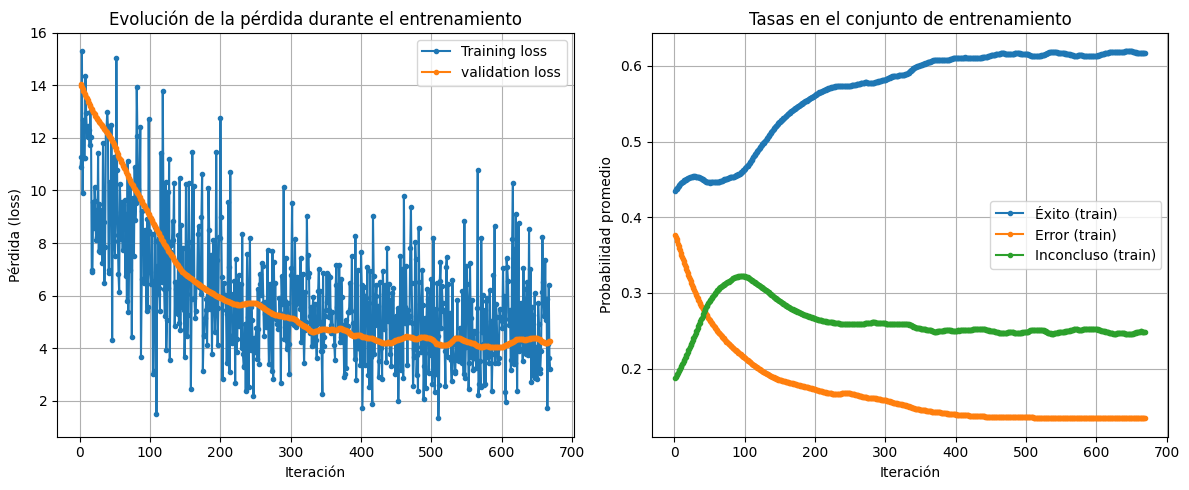

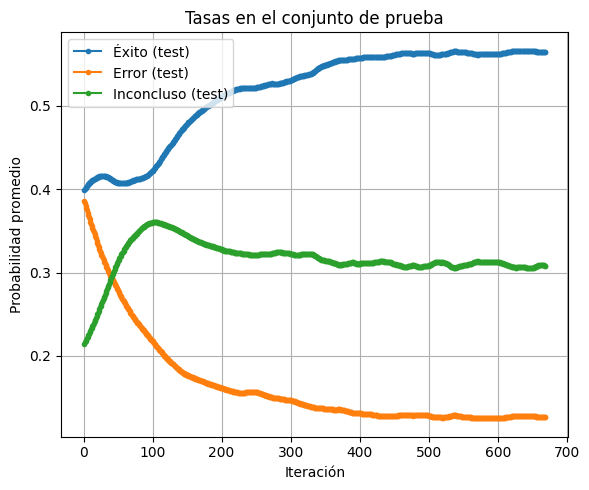

In [13]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+1), val_loss_history, '.-', label="validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+1), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+1), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+1), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+1), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

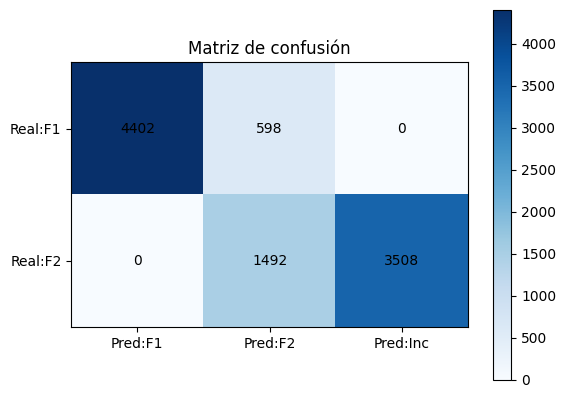

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
